In [ ]:
import yfinance as yf
# refer - https://algotrading101.com/learn/yfinance-guide/

# YT VIDEOS
portfolio optimisation - 
https://www.youtube.com/watch?v=9GA2WlYFeBU


# Testing Basic Moving Avergae Technique

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd


In [4]:
data = yf.download("TCS.NS", start=START_DATE, end=END_DATE)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2020-01-01,1979.162109,1994.044908,1966.744322,1979.527247,1354908
2020-01-02,1970.077148,1990.438569,1962.361784,1990.438569,2380752
2020-01-03,2009.338623,2029.745738,1975.874843,1975.874843,4655761
2020-01-06,2009.156860,2032.440053,1997.697833,2013.311357,3023209
2020-01-07,2014.086792,2022.121595,1993.953641,2009.201800,2429317


In [23]:
# Parameters
INITIAL_CAPITAL = 10000  # Starting cash
STOCK = "AAPL"  # Stock to trade
SHORT_WINDOW = 5  # Short moving average window
LONG_WINDOW = 20  # Long moving average window

# Fetch historical data
data = yf.download(STOCK, period="6mo", interval="1d")

# Ensure data is available
if data.empty:
    print("No data available. Check the stock symbol or internet connection.")
    exit()

# Calculate moving averages
data['SMA_Short'] = data['Close'].rolling(SHORT_WINDOW).mean()
data['SMA_Long'] = data['Close'].rolling(LONG_WINDOW).mean()

# Drop NaN values
data.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [24]:
# Simulate Trading
capital = INITIAL_CAPITAL
shares_held = 0
trades = []

for i in range(len(data)):
    short_sma = data['SMA_Short'].iloc[i].item()  # Fix: Extract scalar value
    long_sma = data['SMA_Long'].iloc[i].item()  # Fix: Extract scalar value
    close_price = data['Close'].iloc[i].item()  # Fix: Extract scalar value

    if np.isnan(short_sma) or np.isnan(long_sma) or np.isnan(close_price):
        continue  # Skip iteration if any value is NaN

    if short_sma > long_sma and capital >= close_price:
        # Buy as much as possible
        shares_to_buy = capital // close_price
        capital -= shares_to_buy * close_price
        shares_held += shares_to_buy
        trades.append((data.index[i], "BUY", shares_to_buy, close_price))

    elif short_sma < long_sma and shares_held > 0:
        # Sell all shares
        capital += shares_held * close_price
        trades.append((data.index[i], "SELL", shares_held, close_price))
        shares_held = 0

# Final Portfolio Value
final_value = capital + (shares_held * data['Close'].iloc[-1].item())  # Fix: Extract scalar value

# Print Trades
print("Trades Executed:")
for trade in trades:
    print(f"Date: {trade[0]}, Action: {trade[1]}, Shares: {trade[2]}, Price: {trade[3]:.2f}")

# Print Final Portfolio Value
print(f"Final Portfolio Value: ${final_value:.2f}")


Trades Executed:
Date: 2024-10-22 00:00:00, Action: BUY, Shares: 42.0, Price: 235.34
Date: 2024-11-01 00:00:00, Action: SELL, Shares: 42.0, Price: 222.42
Date: 2024-11-20 00:00:00, Action: BUY, Shares: 41.0, Price: 228.75
Date: 2025-01-03 00:00:00, Action: SELL, Shares: 41.0, Price: 243.09
Date: 2025-01-31 00:00:00, Action: BUY, Shares: 42.0, Price: 235.74
Date: 2025-02-07 00:00:00, Action: SELL, Shares: 42.0, Price: 227.38
Date: 2025-02-12 00:00:00, Action: BUY, Shares: 40.0, Price: 236.87
Date: 2025-03-04 00:00:00, Action: SELL, Shares: 40.0, Price: 235.93
Final Portfolio Value: $9656.65


# Portfolio Selection Simiulation

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Configuration
np.random.seed(42)
INITIAL_INVESTMENT = 1000000  # ₹10 lakh
START_DATE = '2020-01-01'
END_DATE = '2025-02-28'

# List of NSE stocks
nse_stocks = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 
    'INFY.NS', 'ITC.NS', 'SBIN.NS',
    'HINDUNILVR.NS', 'BAJFINANCE.NS', 'WIPRO.NS', 'ONGC.NS'
]


In [3]:
def calculate_adjusted_close(ticker):
    """Calculate Adjusted Close incorporating splits and dividends"""
    stock = yf.Ticker(ticker)
    hist = stock.history(start=START_DATE, end=END_DATE)
    
    if hist.empty:
        print(f"No data for {ticker}")
        return pd.Series()
    
    # Get corporate actions
    splits = stock.splits
    dividends = stock.dividends
    
    # Initialize adjustment factor
    adj_factor = 1.0
    adj_close = hist['Close'].copy()
    
    # Combine all corporate actions sorted by date
    actions = pd.concat([
        splits.rename('split'),
        dividends.rename('dividend')
    ], axis=1).sort_index(ascending=False)
    
    # Apply adjustments in reverse chronological order
    for date, row in actions.iterrows():
        # Check if date exists in historical data
        if date > hist.index[-1] or date < hist.index[0]:
            continue
            
        # Get valid price data
        price_slice = hist.loc[:date]
        if price_slice.empty:
            continue
            
        close_price = price_slice['Close'].iloc[-1]
        
        if pd.notna(row['split']):
            split_ratio = row['split']
            adj_factor *= split_ratio
            adj_close.loc[:date] *= split_ratio
            
        if pd.notna(row['dividend']):
            dividend = row['dividend']
            adj_factor *= (1 - dividend/close_price)
            adj_close.loc[:date] *= (1 - dividend/close_price)
    
    return adj_close.rename(ticker)
    
def fetch_nse_data(tickers):
    """Fetch and calculate adjusted closes for all tickers"""
    adjusted_data = pd.DataFrame()
    
    for ticker in tickers:
        adj_close = calculate_adjusted_close(ticker)
        if not adj_close.empty:
            adjusted_data[ticker] = adj_close
            
    if adjusted_data.empty:
        raise ValueError("No valid stock data found for given tickers")
        
    return adjusted_data.dropna(axis=1)
    
# Fetch and clean data
price_data = fetch_nse_data(nse_stocks)
returns = price_data.pct_change().dropna()

In [4]:
price_data.head()

,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,ITC.NS,SBIN.NS,HINDUNILVR.NS,BAJFINANCE.NS,WIPRO.NS,ONGC.NS
Date,,,,,,,,,,
2020-01-01 00:00:00+05:30,1361.584015,1798.590547,1176.727745,589.165519,149.783012,295.622730,1660.429644,4090.862874,229.371350,58.007341
2020-01-02 00:00:00+05:30,1384.764250,1790.334576,1184.228420,587.446455,150.883883,299.909619,1661.715990,4105.122857,229.926961,58.280420
2020-01-03 00:00:00+05:30,1386.432832,1826.014198,1167.340461,596.481586,150.034627,294.959771,1652.627253,4054.269100,232.519790,58.462476
2020-01-06 00:00:00+05:30,1354.278285,1825.848131,1142.077276,590.764608,147.895792,281.966300,1642.338061,3864.049020,233.492079,57.461187
2020-01-07 00:00:00+05:30,1375.113437,1830.329051,1160.161730,582.009399,148.053040,281.435973,1646.839766,3874.635512,236.316394,57.233607


In [5]:
# Portfolio optimization functions
def portfolio_performance(weights, returns):
    port_return = np.sum(returns.mean() * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sharpe_ratio = port_return / port_volatility
    return port_return, port_volatility, sharpe_ratio

def monte_carlo_simulation(returns, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.dirichlet(np.ones(len(returns.columns)))
        port_return, port_volatility, sharpe_ratio = portfolio_performance(weights, returns)
        results[0,i] = port_return
        results[1,i] = port_volatility
        results[2,i] = sharpe_ratio
        weights_record.append(weights)
    
    return results, weights_record

In [6]:
# Run simulation
sim_results, weights = monte_carlo_simulation(returns)

# Find optimal portfolios
max_sharpe_idx = np.argmax(sim_results[2])
optimal_weights = weights[max_sharpe_idx]

min_vol_idx = np.argmin(sim_results[1])
min_vol_weights = weights[min_vol_idx]

def analyze_portfolio(price_data, weights, initial_investment):
    """Analyze portfolio performance with given weights"""
    portfolio_value = (price_data / price_data.iloc[0]) * weights * initial_investment
    portfolio_total = portfolio_value.sum(axis=1)
    
    returns = portfolio_total.pct_change().dropna()
    cumulative_returns = (portfolio_total[-1] / initial_investment - 1) * 100
    
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (returns.mean() * 252) / volatility
    max_drawdown = (portfolio_total / portfolio_total.cummax() - 1).min()
    
    return {
        'Final Value': round(portfolio_total[-1], 2),
        'Cumulative Return (%)': round(cumulative_returns, 2),
        'Annual Volatility': round(volatility, 3),
        'Sharpe Ratio': round(sharpe_ratio, 3),
        'Max Drawdown': round(max_drawdown, 3),
        'Weights': {stock: round(wt*100, 2) for stock, wt in zip(price_data.columns, optimal_weights)}
    }

In [7]:
# Analyze optimal portfolios
print("=== Maximum Sharpe Ratio Portfolio ===")
max_sharpe_results = analyze_portfolio(price_data, optimal_weights, INITIAL_INVESTMENT)
for k, v in max_sharpe_results.items():
    print(f"{k}: {v}")

print("\n=== Minimum Volatility Portfolio ===")
min_vol_results = analyze_portfolio(price_data, min_vol_weights, INITIAL_INVESTMENT)
for k, v in min_vol_results.items():
    print(f"{k}: {v}")


=== Maximum Sharpe Ratio Portfolio ===
Final Value: 2869248.54
Cumulative Return (%): 186.92
Annual Volatility: 0.21
Sharpe Ratio: 1.094
Max Drawdown: -0.362
Weights: {'RELIANCE.NS': 3.9, 'TCS.NS': 2.99, 'HDFCBANK.NS': 0.55, 'INFY.NS': 40.11, 'ITC.NS': 22.62, 'SBIN.NS': 1.02, 'HINDUNILVR.NS': 2.93, 'BAJFINANCE.NS': 3.59, 'WIPRO.NS': 2.55, 'ONGC.NS': 19.74}

=== Minimum Volatility Portfolio ===
Final Value: 1964820.17
Cumulative Return (%): 96.48
Annual Volatility: 0.174
Sharpe Ratio: 0.852
Max Drawdown: -0.263
Weights: {'RELIANCE.NS': 3.9, 'TCS.NS': 2.99, 'HDFCBANK.NS': 0.55, 'INFY.NS': 40.11, 'ITC.NS': 22.62, 'SBIN.NS': 1.02, 'HINDUNILVR.NS': 2.93, 'BAJFINANCE.NS': 3.59, 'WIPRO.NS': 2.55, 'ONGC.NS': 19.74}


C:\Users\Divyansh\AppData\Local\Temp\ipykernel_1276\4246196494.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_returns = (portfolio_total[-1] / initial_investment - 1) * 100
C:\Users\Divyansh\AppData\Local\Temp\ipykernel_1276\4246196494.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Final Value': round(portfolio_total[-1], 2),
C:\Users\Divyansh\AppData\Local\Temp\ipykernel_1276\4246196494.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

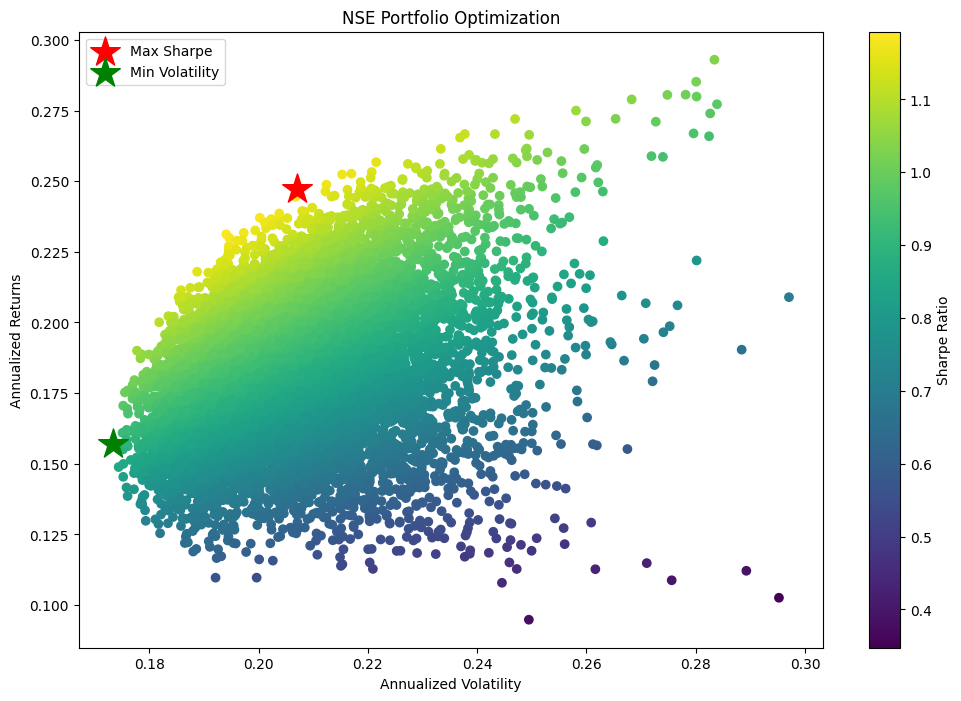

In [8]:
# Plot efficient frontier
plt.figure(figsize=(12, 8))
plt.scatter(sim_results[1], sim_results[0], c=sim_results[2], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(sim_results[1,max_sharpe_idx], sim_results[0,max_sharpe_idx], marker='*', color='r', s=500, label='Max Sharpe')
plt.scatter(sim_results[1,min_vol_idx], sim_results[0,min_vol_idx], marker='*', color='g', s=500, label='Min Volatility')
plt.title('NSE Portfolio Optimization')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.legend()
plt.show()

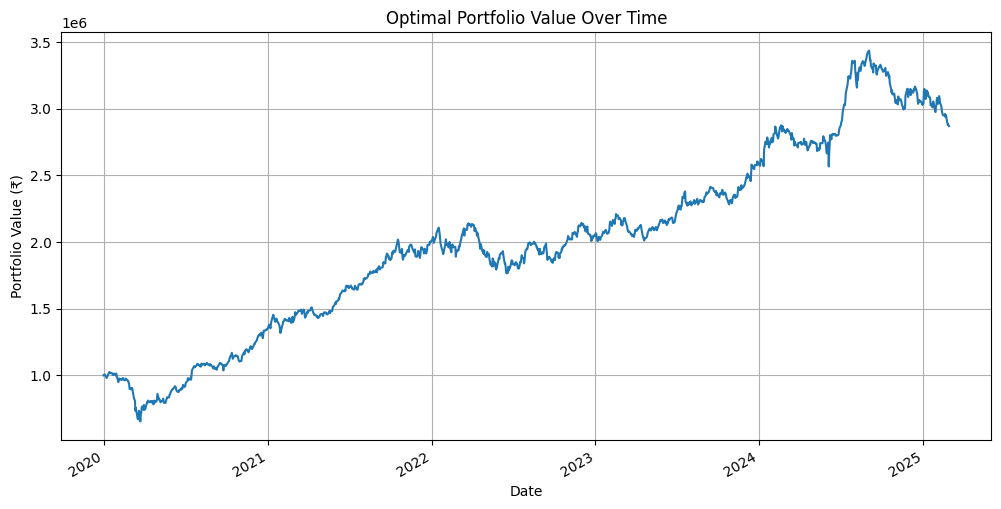

In [9]:
# Plot portfolio value over time
portfolio_value = (price_data / price_data.iloc[0]) * optimal_weights * INITIAL_INVESTMENT
portfolio_total = portfolio_value.sum(axis=1)
plt.figure(figsize=(12, 6))
portfolio_total.plot()
plt.title('Optimal Portfolio Value Over Time')
plt.ylabel('Portfolio Value (₹)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [27]:
nifty50 = yf.download('^NSEI', start=START_DATE, end=END_DATE, auto_adjust=False)
nifty50_close = nifty50['Adj Close']
nifty50_normalized = (nifty50_close / nifty50_close.iloc[0]) * INITIAL_INVESTMENT

# Step 2: Calculate portfolio value
portfolio_value = (price_data / price_data.iloc[0]) * optimal_weights * INITIAL_INVESTMENT
portfolio_total = portfolio_value.sum(axis=1)


[*********************100%***********************]  1 of 1 completed


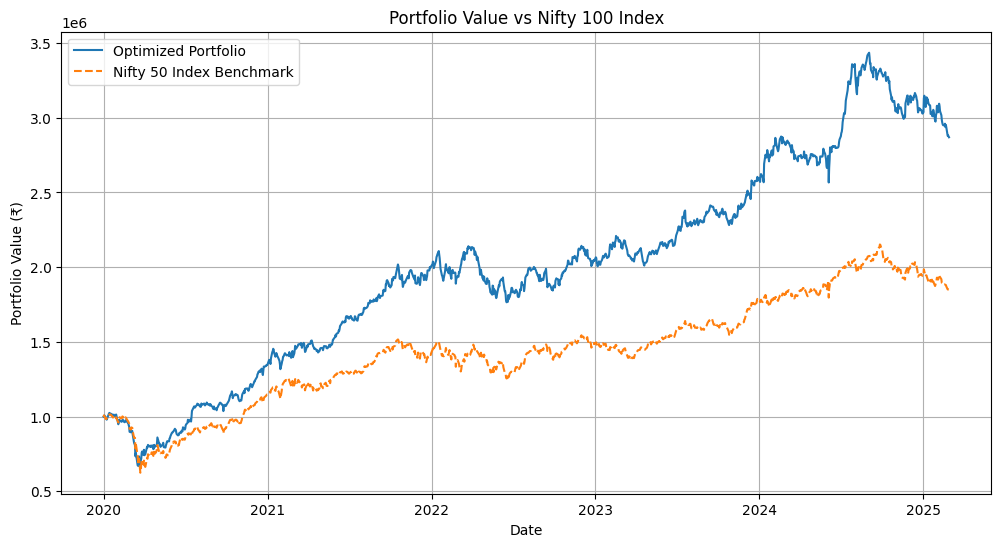

In [39]:
# Convert datetime index to date for portfolio
# portfolio_total.index = portfolio_total.index.date

# Ensure Nifty 50 series is a Series and also has a date index
nifty50_series = nifty50_normalized.squeeze()
nifty50_series.index = nifty50_series.index.date

# Combine and align both
aligned_df = pd.concat([portfolio_total, nifty50_series], axis=1, join='inner')
aligned_df.columns = ['Optimized Portfolio', 'Nifty 50 Index Benchmark']

# Plot
plt.figure(figsize=(12, 6))
aligned_df['Optimized Portfolio'].plot(label='Optimized Portfolio')
aligned_df['Nifty 50 Index Benchmark'].plot(label='Nifty 50 Index Benchmark', linestyle='--')
plt.title('Portfolio Value vs Nifty 100 Index')
plt.ylabel('Portfolio Value (₹)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Inputs
initial_investment = 1000000  # ₹10 lakh
final_value = 2571338.47         # ₹15 lakh
start_year = 2020
end_year = 2024
annual_inflation = 0.05       # 5%

# Calculate
years = end_year - start_year
inflation_factor = (1 + annual_inflation) ** years
real_final_value = final_value / inflation_factor
real_profit = real_final_value - initial_investment

print(f"Nominal Profit: ₹{final_value - initial_investment:,.2f}")
print(f"Real Profit (After Inflation): ₹{real_profit:,.2f}")

Nominal Profit: ₹1,571,338.47
Real Profit (After Inflation): ₹1,115,446.52


# Metrics:
- Cumulative Return: Total percentage gain/loss.
- Volatility: How much the portfolio fluctuates in value.
- Sharpe Ratio: How good the return is compared t the risk taken.
- Max Drawdown: The worst drop in portfolio value.